In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
# Standard python libraries
import os
import requests

# Essential DS libraries
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, roc_curve, RocCurveDisplay, auc, precision_score, roc_auc_score, accuracy_score, f1_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
import seaborn as sns

# Experiments block
import wandb


pd.set_option('display.max_columns', None)

In [3]:
# Подготовим инфраструктуру для версионирования экспериментов
project_name = "Makarov_mfdp_unit_5"
exp_name = "exp_"
config = []

## Эксперимент 5 Кросс-валидация для всех
Произведём кросс валидацию для экспериментов 1-3. На самом деле это один и тот же механизм каждый раз, для одной и той же модели с разным фича селекшеном.

In [21]:
outliers_data_1 = pd.read_csv("1_best_features_out.csv")
outliers_data_2 = pd.read_csv("2_best_features_permutation.csv")
outliers_data_3 = pd.read_csv("3_best_features_mRMR.csv")
outliers_data_y = pd.read_csv("1_outliers_raw_data")["TARGET"]

In [6]:
K = 5
kf = KFold(n_splits = K, random_state = 42, shuffle = True)

In [7]:
catboost_model = CatBoostClassifier(
    iterations=200,  # Modify this parameter as needed
    thread_count=8, 
    custom_metric = ['F1:use_weights=true', 
                     'Precision:use_weights=true', 
                     'Recall:use_weights=true', 
                     'Accuracy:use_weights=true', 
                     'NormalizedGini:use_weights=true'],
    eval_metric='AUC',  # Changed to AUC
    auto_class_weights='Balanced' ,
    verbose=100,  # Output the training process every 100 iterations
    random_seed=42,
    
)

In [8]:
# Первый эксперимент
X = outliers_data_1.drop(["TARGET", "SK_ID_CURR"], axis=1)
y = outliers_data_y
gini_scores = []
train_X_cv, test_X_cv, train_y_cv, test_y_cv = train_test_split(X, y, train_size=0.8, random_state=42)
y_test_pred = 0

In [13]:
# Второй эксперимент
X = outliers_data_2
y = outliers_data_y
gini_scores = []
train_X_cv, test_X_cv, train_y_cv, test_y_cv = train_test_split(X, y, train_size=0.8, random_state=42)
y_test_pred = 0

In [22]:
# Третий эксперимент
X = outliers_data_3
y = outliers_data_y
gini_scores = []
train_X_cv, test_X_cv, train_y_cv, test_y_cv = train_test_split(X, y, train_size=0.8, random_state=42)
y_test_pred = 0


Fold  0
Learning rate set to 0.122505
0:	test: 0.7272446	best: 0.7272446 (0)	total: 4.86ms	remaining: 967ms
100:	test: 0.7677714	best: 0.7841790 (32)	total: 459ms	remaining: 450ms
199:	test: 0.7631986	best: 0.7841790 (32)	total: 916ms	remaining: 0us

bestTest = 0.7841790346
bestIteration = 32

Shrink model to first 33 iterations.
  Gini =  0.5683580692605963

Fold  1
Learning rate set to 0.122505
0:	test: 0.7495990	best: 0.7495990 (0)	total: 5.45ms	remaining: 1.08s
100:	test: 0.7970751	best: 0.8105222 (30)	total: 460ms	remaining: 451ms
199:	test: 0.7746676	best: 0.8105222 (30)	total: 943ms	remaining: 0us

bestTest = 0.8105221621
bestIteration = 30

Shrink model to first 31 iterations.
  Gini =  0.6210443241023538

Fold  2
Learning rate set to 0.122507
0:	test: 0.7178055	best: 0.7178055 (0)	total: 18.4ms	remaining: 3.67s
100:	test: 0.7953436	best: 0.8047098 (36)	total: 545ms	remaining: 534ms
199:	test: 0.7715874	best: 0.8047098 (36)	total: 1.03s	remaining: 0us

bestTest = 0.8047098288


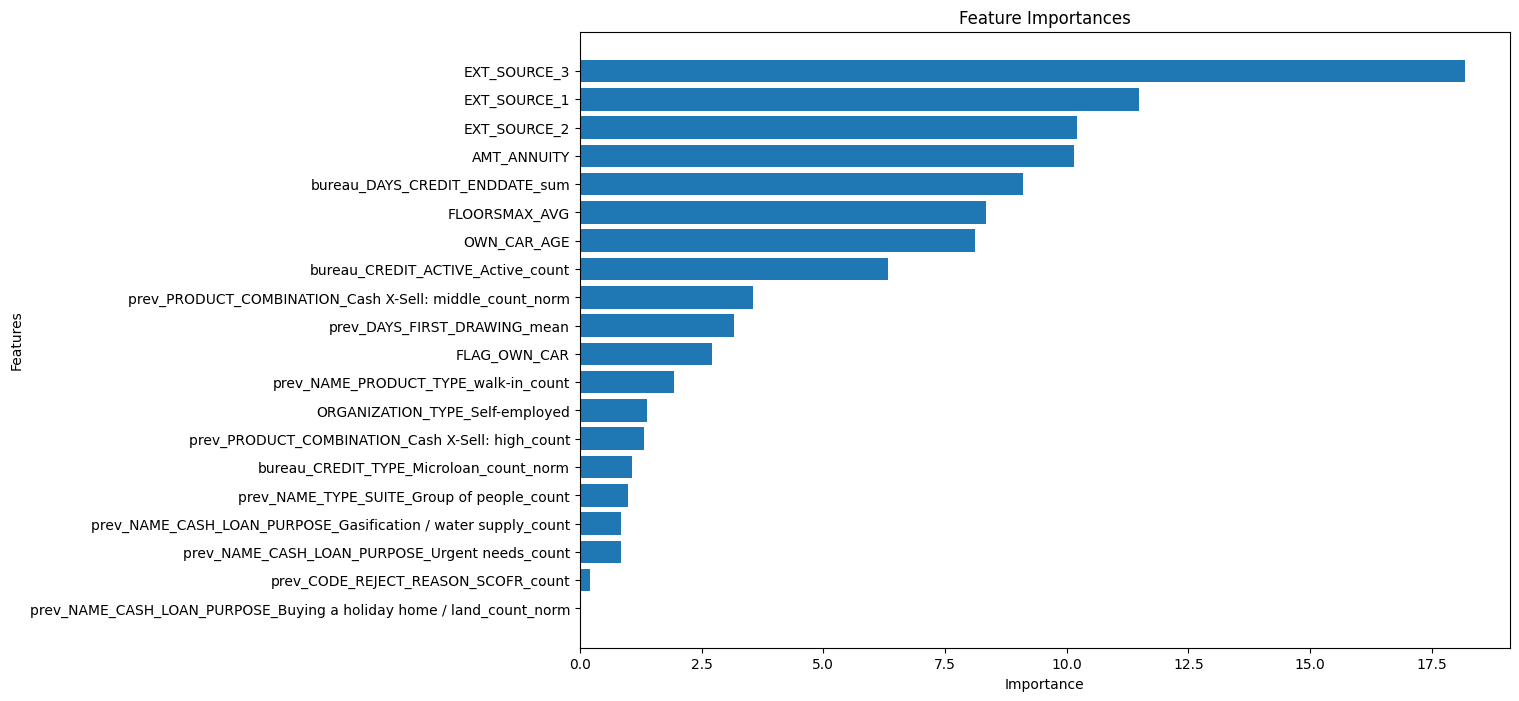

{'learn': {'Accuracy:use_weights=true': 0.9273482339958051,
  'Logloss': 0.26669233839432865,
  'Precision:use_weights=true': 0.8980396060711745,
  'F1:use_weights=true': 0.9299800630276444,
  'Recall:use_weights=true': 0.964935064935065},
 'validation': {'NormalizedGini:use_weights=true': 0.5267386905674987,
  'Accuracy:use_weights=true': 0.7115166042526024,
  'Logloss': 0.5828713186825542,
  'Precision:use_weights=true': 0.7609845483446022,
  'F1:use_weights=true': 0.6648056736874168,
  'Recall:use_weights=true': 0.6585365853658537,
  'AUC': 0.7633693452837493}}

In [23]:
# Замерим метрики на кросс валидации

for i, (train_index, test_index) in enumerate(kf.split(train_X_cv)):

        # Create data for this fold
    y_train, y_valid = train_y_cv.iloc[train_index], train_y_cv.iloc[test_index]
    X_train, X_valid = train_X_cv.iloc[train_index,:], train_X_cv.iloc[test_index,:]
    print( "\nFold ", i)


    # Установочный запуск + иницииализация параметров
    fit_model = catboost_model.fit(X_train, y_train, eval_set=(X_valid, y_valid), use_best_model=True)
    
    # Generate validation predictions for this fold
    pred = fit_model.predict_proba(X_valid)[:,1]
    gini_sc = 2 * roc_auc_score(y_true=y_valid, y_score=pred, average="weighted") - 1
    print( "  Gini = ", gini_sc)
    gini_scores.append(gini_sc )
    y_test_pred += fit_model.predict_proba(train_X_cv)[:,1]
    
mean_gini = sum(gini_scores) / len(gini_scores)
y_test_pred /= K    

# Get feature importances
feature_importances = fit_model.get_feature_importance()

# Create a pandas dataframe for easier visualization
importance_df = pd.DataFrame({
    'Features': X_train.columns,
    'Importance': feature_importances
})

# Sort the dataframe based on the feature importances
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Features'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()
fit_model.get_best_score()

In [24]:
y_test_pred_dr = fit_model.predict_proba(test_X_cv)
print(accuracy_score(y_true=test_y_cv, y_pred=y_test_pred_dr[:,1].round()))
print(roc_auc_score(y_true=test_y_cv, y_score=y_test_pred_dr[:,1], average="weighted"))
print(classification_report(test_y_cv, y_test_pred_dr[:,1].round()))

0.8002283105022832
0.7680300242130752
              precision    recall  f1-score   support

           0       0.97      0.81      0.88      4130
           1       0.16      0.58      0.25       250

    accuracy                           0.80      4380
   macro avg       0.56      0.70      0.57      4380
weighted avg       0.92      0.80      0.85      4380



In [25]:
y_pred = y_test_pred_dr[:,1]
y = test_y_cv

wandb.init(
        project=project_name, name=exp_name+"5.1"+"_3rd_tss_CB_cv"
    )  # Инициализация эксперимента, project - название проекта
wandb.log(
    {
        "accuracy_score": accuracy_score(y_true=y, y_pred=y_pred.round()),
        "f1_score_weighted": f1_score(y_true=y, y_pred=y_pred.round(), average="weighted"),
        "precision_weighted": precision_score(y_true=y, y_pred=y_pred.round(), average="weighted"),
        "roc_auc_score": roc_auc_score(y_true=y, y_score=y_pred, average="weighted"),
        "gini": 2 * roc_auc_score(y_true=y, y_score=y_pred, average="weighted") - 1
    }
)
wandb.sklearn.plot_roc(y_true = y, y_probas = y_test_pred_dr)
#wandb.sklearn.plot_class_proportions(y_train, y_test)
wandb.finish()

accuracy_score,▁
f1_score_weighted,▁
gini,▁
precision_weighted,▁
roc_auc_score,▁
accuracy_score,0.80023
f1_score_weighted,0.84854
gini,0.53606
precision_weighted,0.92369
roc_auc_score,0.76803


### Выводы эксперимента №5
Обучение на кросс-валидации даёт чуть меньшее качество на отложенной выборке, нежели базовые алгоритмы. 
Выбор лучшей модели на фолде требует ручного запоминания параметров модели и их метрик на каждой фолде с последующей сортировкой. Встроенных в CB механизмов такого рода не существует, о чём написано в этом ноутбуке https://github.com/catboost/tutorials/blob/master/cross_validation/cv_tutorial.ipynb.
Учитывая превосходство модели lightGBM на CV тюнинге по сравнению с любым другим результатом, проведение дальнейших работ по кросс-валидации признано мной не целесообразным.